In [1]:
import sys
import os
parent_dir = os.path.dirname(os.getcwd())
sys.path.insert(0, parent_dir)
import src

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [95]:
browse = pd.read_csv('../data/unzipped/pgaddiso-novideo-vpn-linux-20201109-0.csv')
stream = pd.read_csv('../data/unzipped/pgaddiso-youtube-1x-720p-vpn-linux-clean-20201102b-5.csv')

b = src.pipeline(browse)
s = src.pipeline(stream)

## Utilizing signal processing

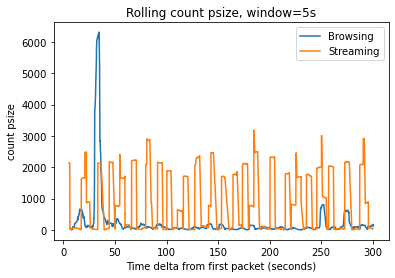

In [96]:
src.charts.compare_rolling(b, s, 'psize', 5, 'count')

We have **highly periodic rolling features** for streaming. It would be nice to summarize the degree of periodicity with a single number.

Hey wait -- signal processing is literally a field of study that exists!

Perhaps we should look at the 'Burstiness' of a time series, could be measured by [Fano factor](https://en.wikipedia.org/wiki/Fano_factor).

In [97]:
def burstiness(ser):
    return ser.var() / ser.mean()

In [98]:
seconds = 5
broll = src.features.roll(b, 'psize', seconds, 'count')
sroll = src.features.roll(s, 'psize', seconds, 'count')

In [99]:
burstiness(broll)

2298.399897974576

In [100]:
burstiness(sroll)

452.9876558638062

Hold your horses. What happens if we get rid of that one huge spike in browsing activity?

In [101]:
burstiness(broll[broll.index > '50s'])

198.40301287818312

Shucks. Burstiness doesn't necessarily show up in browsing if there is little activity overall. This is not going to be consistent.

Truly, I want to measure *periodicity*. Maybe it's time to bring in good ol' Fourier.

In [102]:
def fourier(ser):
    """
    We can look at the sine waves which compose our signal. The wave with the
    greatest magnitude defines the common period in our data, and the magnitude
    itself represents how strong that periodicity is.
    """
    w = np.fft.fft(ser.dropna())
    # The greatest magnitude is basically always zero -- per-datum signals. We
    # must ignore it to find actual periodicity.
    ww = np.abs(w)[1:]
    return ww.max().round(), ww.argmax()

In [103]:
fourier(broll)

(15713614.0, 0)

In [104]:
fourier(sroll)

(10918634.0, 22)

Is *this* a consistent differentiator?

I'm just going to use `.resample` to bin my data. Not ideal but oh well.

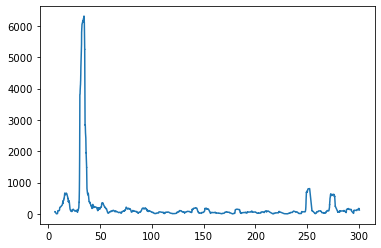

In [116]:
plt.plot(broll.index.total_seconds(), broll)

In [117]:
broll.resample('60s').agg(fourier)

ptime
0 days 00:00:00    (10758297.0, 0)
0 days 00:01:00       (21519.0, 2)
0 days 00:02:00       (15613.0, 2)
0 days 00:03:00        (6810.0, 3)
0 days 00:04:00      (261926.0, 1)
0 days 00:05:00         (315.0, 0)
Freq: 60S, Name: psize, dtype: object

([<matplotlib.axis.XTick at 0x7fb2d41a7e80>,
 <a list of 6 Text major ticklabel objects>)

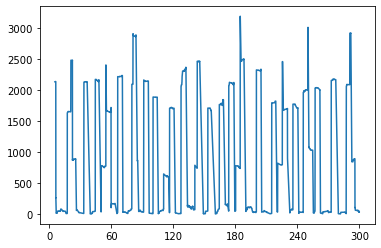

In [119]:
plt.plot(sroll.index.total_seconds(), sroll)
plt.xticks(range(0, 301, 60))

In [106]:
sroll.resample('60s').agg(fourier)

ptime
0 days 00:00:00     (3355927.0, 9562)
0 days 00:01:00    (3182270.0, 11683)
0 days 00:02:00        (2763275.0, 4)
0 days 00:03:00    (3114356.0, 11845)
0 days 00:04:00    (3082089.0, 10395)
Freq: 60S, Name: psize, dtype: object

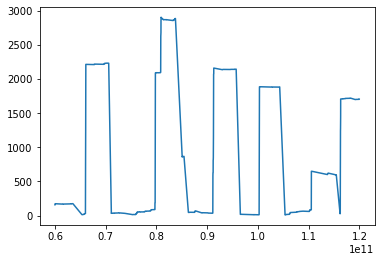

In [136]:
interest = sroll.iloc[list(sroll.resample('60s').indices.values())[1]]
plt.plot(interest)

## Custom window endpoints (emulate stride)

Computing rolling windows takes a long time. But bins are entirely non-overlapping. If we could specify a stride that would be great.

We can use `resample` to essentially bin using a frequency. We can stagger multiple of these.

https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#custom-window-rolling



In [44]:
import pandas.api.indexers as indexers

**Not really working**

In [123]:
b2 = b.copy()
b2.index = b2.index - pd.offsets.Second(30)
b2.resample('60s').indices.keys()

dict_keys([Timedelta('-1 days +23:59:30'), Timedelta('0 days 00:00:30'), Timedelta('0 days 00:01:30'), Timedelta('0 days 00:02:30'), Timedelta('0 days 00:03:30'), Timedelta('0 days 00:04:30')])

In [83]:
# These are the indices belonging to each 60-second bin (non-overlapping)
# [0, 60), [60, 120) ...
bins1 = list(b.resample('60s').indices.values())

# By cutting off first 30s of data, we can get another set of bins
# [30, 90), [90, 150) ...
bins2 = list(b[b.index >= '30s'].resample('60s').indices.values())

# Interleave the two
overlapping_bins = [val for pair in zip(bins1, bins2) for val in pair]

In [56]:
idxr = indexers.VariableOffsetWindowIndexer(b.index, pd.offsets.BDay(1))
idxr.get_window_bounds()

TypeError: 'NoneType' object is not subscriptable

## Striding windows

Computing rolling windows takes a *long* time. But bins are entirely non-overlapping. If we could specify a stride that would be great.

https://stackoverflow.com/questions/40084931/taking-subarrays-from-numpy-array-with-given-stride-stepsize

To test consistency we can:
1. Compute the desired rolling window for the entire data -- this is the rolling window used to generate a statistic.
2. Create a strided timedelta index forming the indices of our overlapping bins.

In [17]:
trange = pd.timedelta_range('0s', '300s', freq='1s')

In [37]:
def strided(a, L, S ):  # Window len = L, Stride len/stepsize = S
    nrows = ((a.size-L)//S)+1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows,L), strides=(S*n,n))

In [39]:
strided(trange.values, 60, 10)

array([[           0,   1000000000,   2000000000, ...,  57000000000,
         58000000000,  59000000000],
       [ 10000000000,  11000000000,  12000000000, ...,  67000000000,
         68000000000,  69000000000],
       [ 20000000000,  21000000000,  22000000000, ...,  77000000000,
         78000000000,  79000000000],
       ...,
       [220000000000, 221000000000, 222000000000, ..., 277000000000,
        278000000000, 279000000000],
       [230000000000, 231000000000, 232000000000, ..., 287000000000,
        288000000000, 289000000000],
       [240000000000, 241000000000, 242000000000, ..., 297000000000,
        298000000000, 299000000000]], dtype='timedelta64[ns]')

In [20]:
ar = np.arange(1, 300)

In [22]:
ar.strides

(8,)

In [ ]:
only_70_seconds = lambda df: df[df.index < '70s']
src.charts.compare_rolling(b, s, , filters=[only_70_seconds])

### Side note - a cool trick
Did you know that `series[...]` will return `series`?

---

In [54]:
def burstiness(ser, subwindow, substat):
    """
    To be passed as a stat into `roll`. Compute Fano Factor on sub-windows of
    data.
    """
    
    # This is a *NICE* trick -- indexing ser[...] just returns the ser!
    subroll = src.features.roll(ser, ..., subwindow, substat)
    
    return subroll.var() / subroll.mean()

In [56]:
# fano = lambda df: burstiness(df, 5, 'count')
# src.charts.compare_rolling(b, s, 'psize', 60, fano)

Realizing I was approaching it in a very inefficient way. I can compute the rolling counts first, then just compute a rolling Fano of those counts.

E.g. if we turn the above output into a binary $\mathbf 1(x)\{x>\text{midrange}\}$